In [1]:
import thesis
import geomappy as mp
from geomappy.colors import cmap_2d, plot_colors, add_colorbar
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array, to_hex, ListedColormap, \
    LogNorm, BoundaryNorm, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
import numpy as np

### Preparation

#### Loading dataframe from memory

In [2]:
files = glob.glob("data/df/*feather")

In [3]:
df_list = [pd.read_feather(x) for x in files]
df = pd.concat(df_list)

In [4]:
df.head(10)

,index,wtd,wtd_std,p_pet,climate,landscape,corr_wtd_fapar,corr_p_pet_fapar,corr_p_pet_wtd,classes,th,fapar
0,38368,-20.490117,29.721915,0.379195,29.0,5.0,0.200130,0.800072,-0.192847,7.0,0.17,5.549864
1,38584,-14.522317,16.271340,0.412502,29.0,4.0,0.285191,0.720813,0.295907,8.0,11.39,10.648549
2,38585,-15.395438,17.036641,0.401628,29.0,4.0,0.179361,0.680996,0.244430,7.0,7.63,9.669016
3,38799,-7.435052,16.519695,0.434982,29.0,4.0,0.381691,0.676437,0.323457,8.0,5.26,10.106983
4,22947,-25.158843,28.653745,0.418744,29.0,4.0,0.018269,0.046165,0.009609,4.0,6.31,12.065676
5,22948,-23.835543,44.257091,0.431558,29.0,6.0,-0.188339,-0.168220,0.005543,4.0,4.20,10.851288
6,22949,-37.474326,49.909164,0.444642,29.0,6.0,-0.079549,-0.193000,0.026349,1.0,6.16,9.813579
7,22950,-33.711145,49.400188,0.449378,29.0,6.0,0.070523,0.039825,-0.029649,4.0,4.62,9.065878
8,23355,-2.037080,7.568072,0.310406,29.0,1.0,0.085795,0.585859,-0.201912,7.0,0.97,7.403647
9,23356,-7.345334,14.462574,0.306081,29.0,1.0,0.632794,0.759110,-0.209917,8.0,0.32,7.397507


#### Legends

In [5]:
# Landscape
landscape_classes = ["NAN", "Open water and wetland", "Lowland", "Undulating terrain", "Hilly",
                     "Low mountainous", "Mountainous", "High mountainous"]

In [6]:
# Climate
with open("/Volumes/Elements SE/Thesis/Data/climate/koppen_legend.txt") as f:
    data = f.read().split("\n")

clim_legend = {np.nan:[np.nan]*3,
               0 : [np.nan]*3}
clims = []
major_clims = {np.nan:[np.nan]*3,
               0 : [np.nan]*3}   

for entry in data[3:33]:
    key,string = entry.split(":")
    key = int(key)
    string = string[:string.find("[")].strip()
    clim_class = string[:string.find(" ")].strip()
    clims.append(clim_class)
    clim_descr = string[string.find(" "):].strip()
    major = ord(clim_class[0].lower()) - 96
    if major not in major_clims:
        major_clims[major] = [key]
    else:
        major_clims[major] += [key]
    clim_legend[key] = (major,clim_class,clim_descr)
    
clims = sorted(clims)

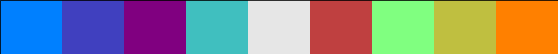

In [7]:
# Colors
cmap = cmap_2d((3,3), alpha=0.5, diverging_alpha=0.25)
cmap[1,1,:] = (0.9,0.9,0.9)
cmap = cmap.reshape((9,-1))
cmap = ListedColormap(cmap)
norm = Normalize(vmin=0, vmax=9)
plot_colors(cmap)

#### Adding legend data into dataframe

In [8]:
df['climate_class'] = df.climate.apply(lambda x: clim_legend[int(x)][1])
df['climate_class_major'] = df.climate.apply(lambda x: clim_legend[int(x)][0])
df['landscape_class'] = df.landscape.apply(lambda x: landscape_classes[int(x)])
df['landscape_class'] = pd.Categorical(df.landscape_class, categories = landscape_classes[1:], ordered = True)
df.loc[:,"classes_centered"] = df.classes
df.loc[df.classes_centered == 4, "classes_centered"] = np.nan
# df.dropna(inplace=True)

#### Heatmaps

In [9]:
label_list = [
    "Oxygen stress",
    "Energy limited",
    "Convergence dominated",
    "Rooting space limited",
    "Neutral",
    "Convergence driven",
    "Rooting space driven/\nPrecipitation driven",
    "Precipitation driven",
    "Water limited"
]

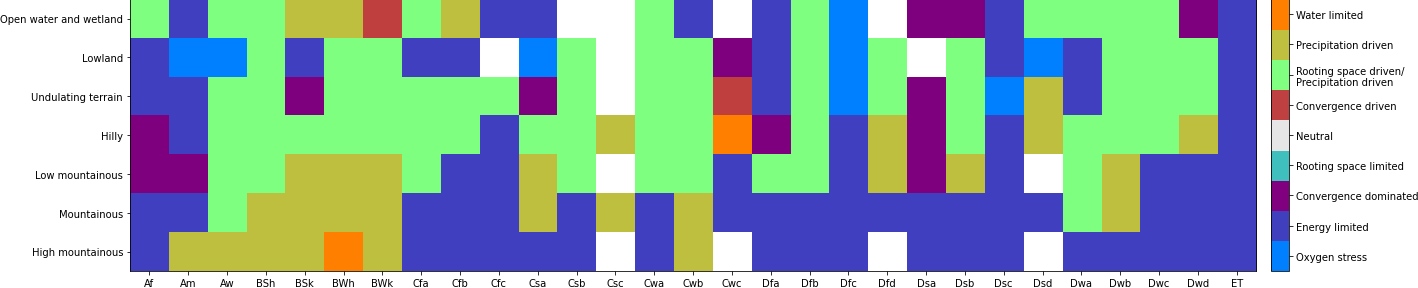

In [10]:
f, ax = plt.subplots(1, figsize = (20,8))
x = df.groupby(['landscape_class','climate_class'])['classes_centered'].agg(lambda x: thesis.mode(x)).unstack()
im = plt.imshow(x, cmap=cmap, norm=norm)

cbar = add_colorbar(im, aspect=15, pad_fraction=0.8)
cbar.set_ticks([x+0.5 for x in (0,1,2,3,4,5,6,7,8,9)])
cbar.ax.set_yticklabels(label_list)

ax.set_xticks(list(range(29)))
ax.set_xticklabels(list(x.columns))
ax.set_yticks(list(range(7)))
ax.set_yticklabels(landscape_classes[1:])

plt.tight_layout()
plt.savefig("figures/si_heatmap_classes.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

/Users/jroebroek/opt/anaconda3/envs/thesis/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


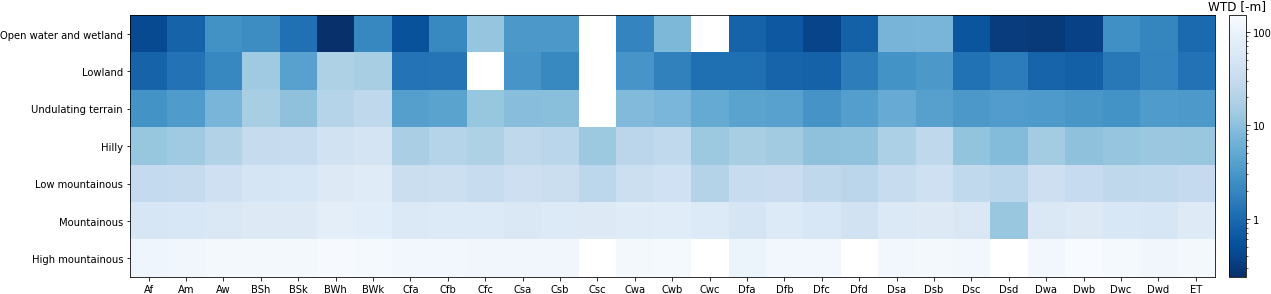

In [11]:
f, ax = plt.subplots(1, figsize = (20,8))
x = df.groupby(['landscape_class','climate_class'])['wtd'].mean().unstack()*-1
im = plt.imshow(x, cmap = "Blues_r", norm=LogNorm())
cbar = add_colorbar(im, aspect=15, pad_fraction=0.8, format=ScalarFormatter())
cbar.ax.set_title("WTD [-m]")

ax.set_xticks(list(range(29)))
ax.set_xticklabels(list(x.columns))
ax.set_yticks(list(range(7)))
ax.set_yticklabels(landscape_classes[1:])

plt.savefig("figures/si_heatmap_wtd.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

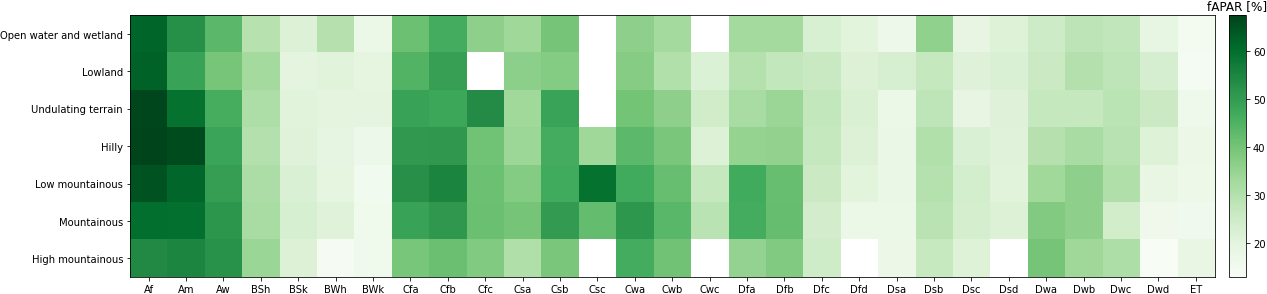

In [12]:
f, ax = plt.subplots(1, figsize = (20,8))
x = df.groupby(['landscape_class','climate_class'])['fapar'].mean().unstack()
im = plt.imshow(x, cmap = "Greens")
cbar = add_colorbar(im, aspect=15, pad_fraction=0.8)
cbar.ax.set_title("fAPAR [%]")

ax.set_xticks(list(range(29)))
ax.set_xticklabels(list(x.columns))
ax.set_yticks(list(range(7)))
ax.set_yticklabels(labels=landscape_classes[1:])

plt.savefig("figures/si_heatmap_fapar.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [13]:
choice = ['BWh', 'Cfa', 'Dfa', 'Af']

In [14]:
df.groupby("climate_class")['p_pet'].mean()[choice]

climate_class
BWh    0.114237
Cfa    0.901245
Dfa    0.689819
Af     1.859424
Name: p_pet, dtype: float64

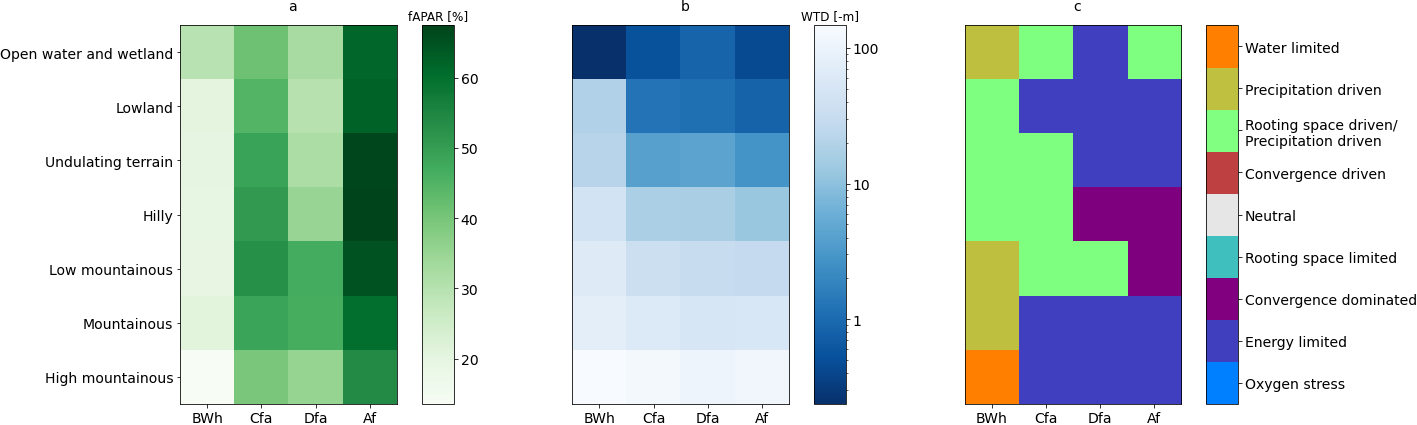

In [15]:
f, ax = plt.subplots(1, 3, figsize = (18,6), constrained_layout=True)
fontsize = 14

# FAPAR
im = ax[0].imshow(df.groupby(['landscape_class','climate_class'])['fapar'].mean().unstack().loc[:,choice], 
                  cmap ="Greens")
cbar = add_colorbar(im, ax=ax[0], aspect=12, pad_fraction=0.8)

cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_title("fAPAR [%]")

ax[0].set_yticks(list(range(7)))
ax[0].set_yticklabels(landscape_classes[1:], fontsize = fontsize)
ax[0].set_xticks(list(range(len(choice))))
ax[0].set_xticklabels(choice, fontsize = fontsize)

ax[0].text(0.5,1.04, 'a', transform=ax[0].transAxes, size=14)

# WTD
im = ax[1].imshow(df.groupby(['landscape_class','climate_class'])['wtd'].mean().unstack().loc[:,choice]*-1, 
                  cmap="Blues_r", norm=LogNorm())

ax[1].set_xticks(list(range(len(choice))))
ax[1].set_xticklabels(choice, fontsize = fontsize)
ax[1].set_yticks(())

cbar = add_colorbar(im, ax=ax[1], format=ScalarFormatter(), aspect=12, pad_fraction=0.8)
cbar.ax.tick_params(labelsize=fontsize)
cbar.ax.set_title("WTD [-m]")

ax[1].text(0.5,1.04, 'b', transform=ax[1].transAxes, size=14)

# CLASSES
im = ax[2].imshow(df.groupby(['landscape_class','climate_class'])['classes_centered'].agg(lambda x: thesis.mode(x)).unstack().loc[:,choice], 
                  cmap=cmap, norm=norm)

cbar = add_colorbar(im, ax=ax[2], aspect=12, pad_fraction=0.8)
cbar.set_ticks([x+0.5 for x in (0,1,2,3,4,5,6,7,8,9)])
cbar.ax.set_yticklabels(label_list)
cbar.ax.tick_params(labelsize=fontsize)

ax[2].set_yticks(())
ax[2].set_xticks(list(range(len(choice))))
ax[2].set_xticklabels(choice, fontsize = fontsize)

ax[2].text(0.5,1.04, 'c', transform=ax[2].transAxes, size=14)

# f.tight_layout(wpad=0.2)

plt.savefig("figures/heatmaps.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [16]:
df['landscape_cut'] = pd.cut(df.wtd_std, np.hstack(((0,), np.logspace(0, np.log10(300), num=18))))
df['p_pet_cut'] = pd.cut(df.p_pet, np.arange(0,3.1,0.1))

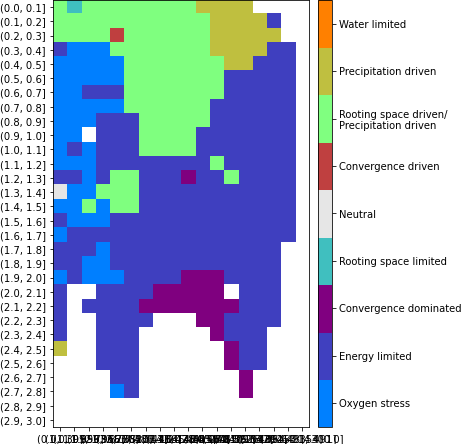

In [17]:
f, ax = plt.subplots(1, figsize = (5, 15))
x = df.groupby(['p_pet_cut','landscape_cut'])['classes'].agg(lambda x: thesis.mode(x) if len(x)>250 else np.nan).unstack()
ax.imshow(x, cmap=cmap, norm=norm)
cbar = add_colorbar(im=ScalarMappable(cmap=cmap, norm=norm))
cbar.set_ticks([x+0.5 for x in (0,1,2,3,4,5,6,7,8,9)])
cbar.ax.set_yticklabels(label_list)

ax.set_xticks(range(len(x.columns)))
ax.set_xticklabels(x.columns)
ax.set_yticks(range(len(x.index)))
ax.set_yticklabels(x.index)

# plt.tight_layout()
# plt.savefig("figures/classes_heatmap_std_p.png")
plt.show()

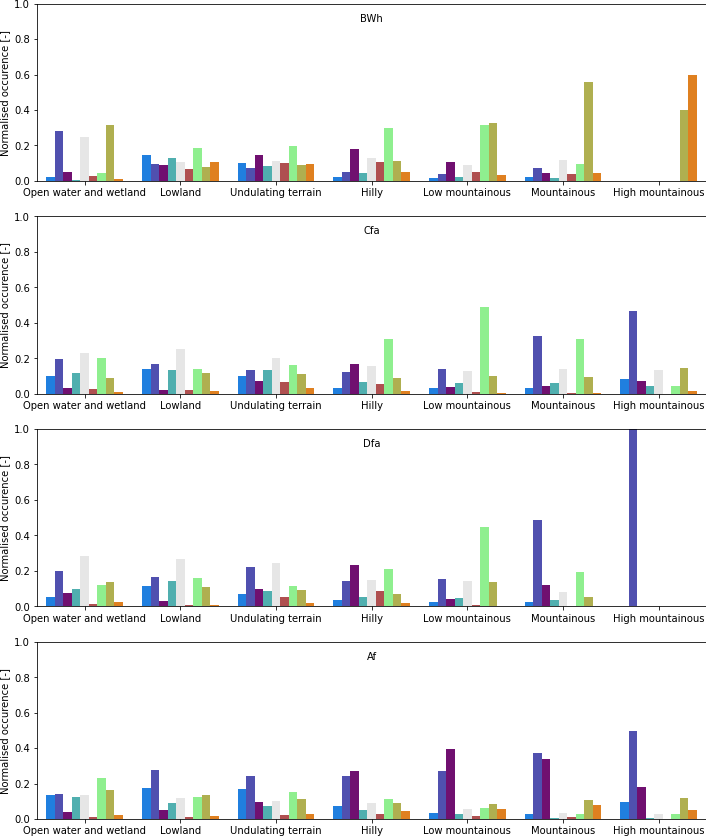

In [18]:
f, ax = plt.subplots(nrows=4, figsize=(12, 15))
ax = ax.flatten()
for i, clim in enumerate(choice):
    df_clim = df.loc[df.climate_class == clim, :]
    x = (df_clim.groupby(["landscape_class", "classes"]).size() / df_clim.groupby("landscape_class").size()).reset_index()
    p = sns.barplot(data=x, x='landscape_class', y=0, hue='classes', palette=cmap.colors, ax=ax[i])
    p.legend_.remove()
    ax[i].set_xlabel("")
    ax[i].set_ylabel("Normalised occurence [-]")
    ax[i].text(.5,.9,clim, ha='center', transform=ax[i].transAxes)
    ax[i].set_ylim(0, 1)
plt.savefig("figures/distribution_classes_choice_climates.png", bbox_inches='tight', pad_inches=0, dpi=300)

##### Defining the sizes of the trees in the framework

In [19]:
i = 3
print(choice[i])
0.2 * df.loc[df.climate_class == choice[i], :].groupby("landscape_class")['fapar'].mean() - 2

Af


landscape_class
Open water and wetland    10.349118
Lowland                   10.448001
Undulating terrain        11.395390
Hilly                     11.495997
Low mountainous           10.974906
Mountainous                9.995980
High mountainous           8.835479
Name: fapar, dtype: float64